In [1]:
from scipy.fft import fft, ifft, fftshift, fft2, ifft2
from scipy.signal import stft
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import pywt
from scipy.io.wavfile import read as wave_read
%matplotlib inline 

In [2]:
# We need a tool that converts images into grayscale (i.e. all pixel values in [0, 1])
def gray_scale_convert(image):
    rescaled_image = np.zeros((image.shape[0], image.shape[1]))
    rescaled_image[:, :] = image
    rescaled_image -= np.min(rescaled_image)
    rescaled_image /= np.max(rescaled_image)
    return rescaled_image

# Noisy Signals

Just to get a sense of the power of the FFT, we look at the signal 

$$
s(t) = \cos(2t) + \sin(3t) + \epsilon(t),  \epsilon(t) \sim \mathcal{N}(0, 1).
$$

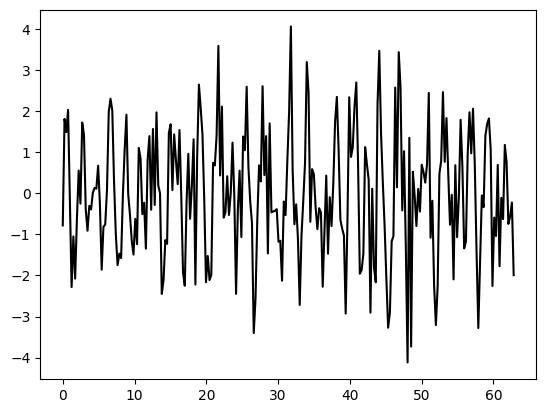

In [3]:
Npts = int(2**8)
times = np.linspace(0., 20.*np.pi, Npts)
rvals = np.random.randn(Npts)
sfun = lambda t: np.cos(2.*t) + np.sin(3.*t)
svals = sfun(times) + rvals

plt.plot(times, svals, 'k')
#plt.plot(times, sfun(times), 'r--')

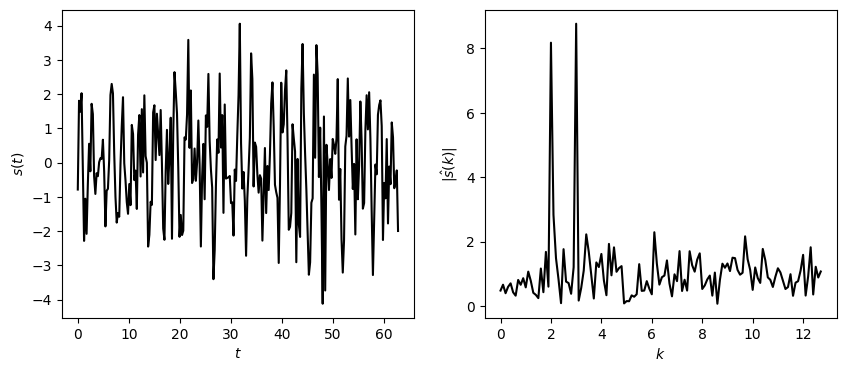

In [4]:
sfreq = fft(svals)
sfreq_plot = np.abs(fftshift(sfreq[:]))/np.sqrt(Npts)
kvals = np.arange(0, int(Npts/2)) * (2.*np.pi)/(20.*np.pi)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(times, svals, 'k')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$s(t)$")

ax[1].plot(kvals, sfreq_plot[int(Npts/2):], 'k')
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$|\hat{s}(k)|$");


So now, if we want to denoise, we use the same kind of threshholding to maximum arguments we used for the SVD.  This looks like:

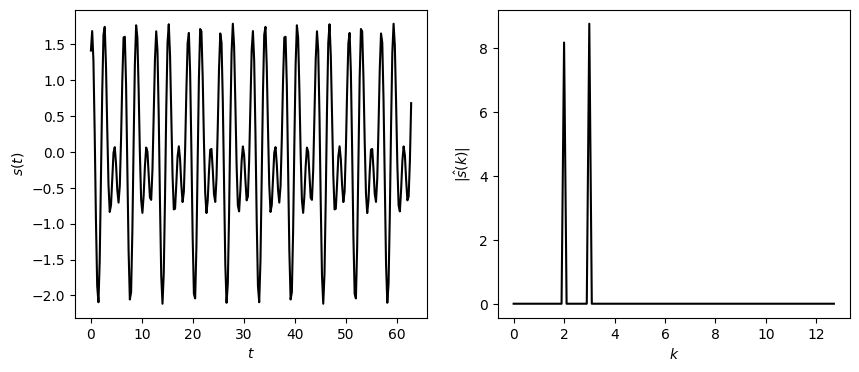

In [5]:
sfmax = np.max(np.abs(sfreq))
indskp = np.ma.log2(np.abs(sfreq)/sfmax) >= -1
sfilter = np.zeros(sfreq.size, dtype=np.complex128)
sfilter[indskp] = sfreq[indskp]
sfilter_plot = fftshift(np.abs(sfilter))/np.sqrt(Npts)
sdenoised = np.real(ifft(sfilter))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(times, sdenoised, 'k')
#ax[0].plot(times, sfun(times), 'r--')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$s(t)$")

ax[1].plot(kvals, sfilter_plot[int(Npts/2):], 'k')
ax[1].set_xlabel(r"$k$")
ax[1].set_ylabel(r"$|\hat{s}(k)|$");


# Image Analysis

Now, what happens when we use the 2D FFT on Beans?  

In [7]:
# Find, load, and convert image from textbook data
# Image is in Lecture_Notes folder 
beans = io.imread('beans.jpg', as_gray=True)

beans_freq = fft2(beans)
beans_freq_plot = np.log10(fftshift(np.abs(beans_freq)))

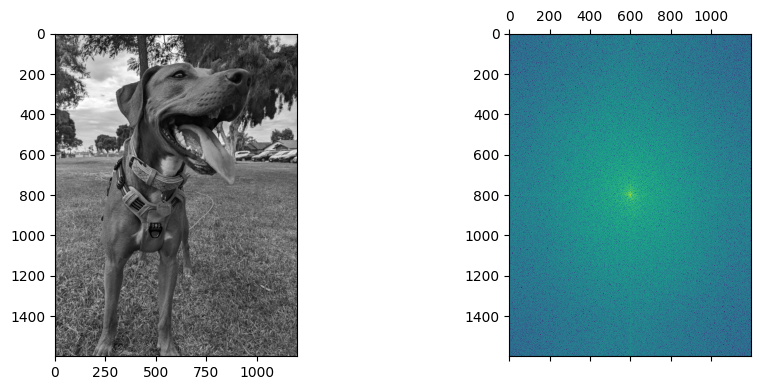

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(beans, cmap=plt.cm.gray)
ax[1].matshow(beans_freq_plot)

plt.tight_layout()

So, there isn't really any clear interpretation of Beans in the FFT plot to the right.  Nevertheless, we can still do useful things with it.  To wit, we can look at, as you might have guessed, amplitude comparisons and only keep large Fourier coefficients.  

In [11]:
max_freq = np.max(np.abs(beans_freq))
indskp = np.ma.log10(np.abs(beans_freq)/max_freq) >= -3
dog_filter = np.zeros((beans_freq.shape[0], beans_freq.shape[1]), dtype=np.complex128)
dog_filter[indskp] = beans_freq[indskp]
beans_reduced = gray_scale_convert(np.real(ifft2(dog_filter)))

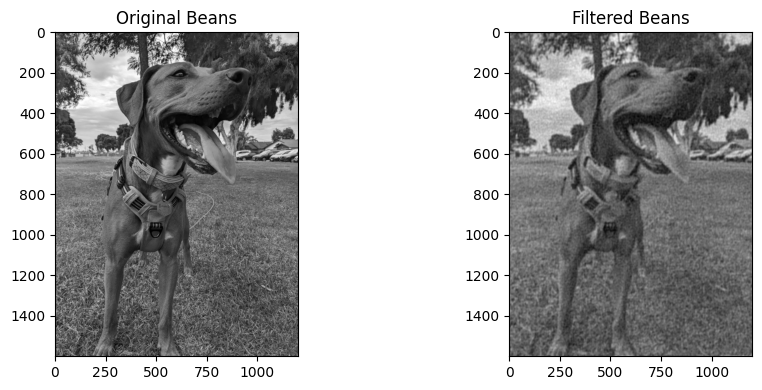

In [157]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].imshow(beans, cmap=plt.cm.gray)
ax[0].set_title("Original Beans")
ax[1].imshow(beans_reduced, cmap=plt.cm.gray)
ax[1].set_title("Filtered Beans")
plt.tight_layout()

So with almost none of the affiliated Fourier spectra, we get a weirdly good recreation of Beans, but in a very different way than what we did with the SVD.  Let's see how the original and altered images look though through that lense.  

In [10]:
u, s, vh = np.linalg.svd(dog_grayscale)
ur, sr, vhr = np.linalg.svd(dog_reduced)

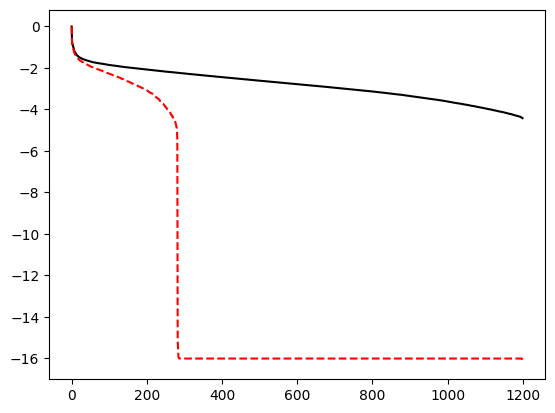

In [11]:
plt.plot(np.ma.log10(s/s[0]), color='k')
plt.plot(np.ma.log10(sr/sr[0]), color='r', ls='--')

So we see our FFT based approach is similar to chopping off dimensions in the SVD, though perhaps not quite as systematic in how we can describe the effect. 

## FFT Theory

For $f(t+T)=f(t)$ with $f(t) \in L_{2}([0, T])$, again, we define the Fourier coefficient $\hat{f}_{n}$ for $n\in \mathbb{Z}$ as 

$$
\hat{f}_{n} = \left<f,\hat{e}_{n}\right> = \frac{1}{\sqrt{T}}\int_{0}^{T}f(t) e^{-2\pi i n t/T} dt.  
$$

With a modicum of theory, we can in turn write

$$
f(t) = \sum_{n=-\infty}^{\infty}\hat{f}_{n}\hat{e}_{n}(t), ~\hat{e}_{n}(t) = \frac{1}{\sqrt{T}}e^{-2\pi i n t/T}.
$$

We can think of the transition from $f(t)$ to the infinte vector $\left(\hat{f}_{n}\right)_{n=-\infty}^{\infty}$ as the _forward_ transform, and the process of summing the terms $\hat{f}_{n}\hat{e}_{n}(t)$ as the _inverse_ transform.  

Now, as we've examined in lecture and the homework, a central issue for Fourier transforms is the rate of decay of $\hat{f}_{n}$.  As we know, if we take 

$$
f(t) = \left\{\begin{array}{rl} 0 & 0 \leq t \leq \pi \\ 1 & \pi < t < 2\pi \end{array}\right.
$$

then 

$$
\hat{f}_{n} = \left\{\begin{array}{rl} \frac{i}{n}\sqrt{\frac{2}{\pi}} & n ~\mbox{odd} \\ 0 & n ~\mbox{even}\end{array}\right.
$$

So that slow rate of decay combined with the limited number of modes of the FFT makes for a tricky situation.  To see what I mean, let's compute.  

In [12]:
def step_fun(t):
    if 0 <= t and t <= np.pi:
        return 0
    else:
        return 1
    
def interp_freq(t, freq):
    Npts = freq.size
    hlf = int(Npts/2)
    tpi = 2.*np.pi
    nvals = np.append(np.arange(0, hlf+1), np.arange(-hlf+1, 0))
    phase = np.exp(nvals * 1j * t)
    return np.real(np.sum(freq * phase))/Npts

In [64]:
Npts = int(2**9)
tvals = np.linspace(0., 2.*np.pi, Npts)
fvals = [step_fun(tval) for tval in tvals]
ffreq = fft(fvals)
ffreq_plot = fftshift(np.abs(ffreq))

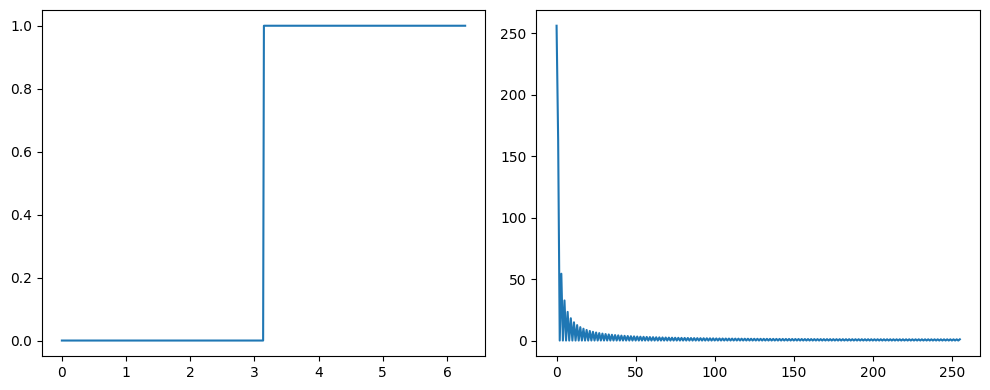

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()

ax[0].plot(tvals, fvals)
ax[1].plot(ffreq_plot[int(Npts/2):])

plt.tight_layout()

In [66]:
tvalsfine = np.linspace(0, 2.*np.pi, 2*Npts)
interp_step = [interp_freq(tval, ffreq) for tval in tvalsfine]

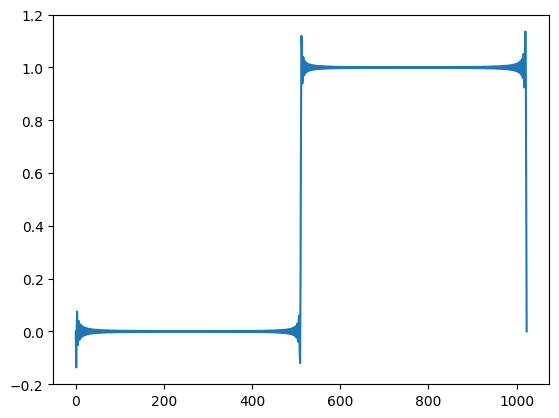

In [67]:
plt.plot(interp_step)

## The Fourier Transform

For $T$-periodic $f(t)$, if we let $T\rightarrow \infty$, we are lead to the trasnforms

$$
\hat{f}(\omega) = \int_{-\infty}^{\infty}e^{-i\omega t}f(t) dt, ~ f(t) = \frac{1}{2\pi}\int_{-\infty}^{\infty} e^{i\omega t}\hat{f}(\omega) d\omega
$$

With these tranforms, we can now study signals which do not necessarily repeat or have any particular structure at all.  To wit, we now look at the pulse

$$
f_{a}(t) = \frac{1}{\sqrt{\pi a}}e^{-t^{2}/a}, ~ a > 0.
$$

We can readily see that 

\begin{align*}
\hat{f}_{a}(\omega) = & \frac{1}{\sqrt{\pi a}}\int_{-\infty}^{\infty}e^{-t^{2}/a - i\omega t}dt\\
 = & \frac{1}{\sqrt{\pi}}\int_{-\infty}^{\infty}e^{-t^{2} - i\sqrt{a}\omega t}dt \\
 = & \frac{1}{\sqrt{\pi}}e^{-a\omega^{2}/4}\int_{-\infty}^{\infty}e^{-(t + i\sqrt{a}\omega/2)^{2}}dt\\
 = & e^{-a\omega^{2}/4}
\end{align*}

So as we let $a\rightarrow 0^{+}$, we get that $f_{a}(t)$ has an ever shorter width ($\mathcal{O}(\sqrt{a}))$ and larger amplitude ($\mathcal{O}(1/\sqrt{a})$) pulse in time, and in frequency space, we see $\hat{f}_{a}(\omega)\rightarrow 1$.  Said another way, the sharper the feature in time we want to resolve, the more information in frequency space that we need to represent it.  This then represents a limit of what we can get from Fourier trasnforms.  

## Short-Time-Fourier Transforms

So what we have seen is that as we want to represent sharper features in time (or space in the context of images), if we want to stick with strict Fourier methods, we run into a wall in which sharper features demand ever more information from frequency space, making any kind of "sparse" or low-memory representation impossible.  

A path out of this conudrum is to start to expand on our Fourier transform in clever ways that allow us to better represent sharp or more intricate features.  One way to do this is through the so called _Gabor_ (or Short-Time-Fourier) transform, defined for $f(t)$ as 

$$
\mathcal{G}(t,\omega)\{f\} = \int_{-\infty}^{\infty}f(\tau)g_{W}(\tau - t)e^{-i\omega \tau} d\tau.  
$$

Here, $g_{W}(s)\geq 0$ and is chosen to have finite support or to decay so quickly it effectively does.  A common choice is to let 

$$
g_{W}(s) = e^{-s^{2}/b}, b > 0.
$$

In this case, we can exactly compute $\mathcal{G}(t,\omega)\{f_{a}\}$, which is 

$$
\mathcal{G}(t,\omega)\{f_{a}\} = \frac{1}{\sqrt{1+\frac{a}{b}}}e^{-t^{2}/(a+b)}e^{-ab\omega^{2}/(4(a+b))}e^{-i\omega t a/(a+b)}.
$$

While certainly a complicated expression, we can use this example to help us build intuition for how short-time Fourier transforms work in practice.  For example, we quickly can see that the transform of our $\mathcal{O}(\sqrt{a})$ wide pulse tracked through a $\mathcal{O}(\sqrt{b})$ width window results in a transform that scales like $\mathcal{O}(\sqrt{a+b})$ in time and $\mathcal{O}(2\sqrt{\frac{1}{a}+\frac{1}{b}})$ wide in frequency space.  

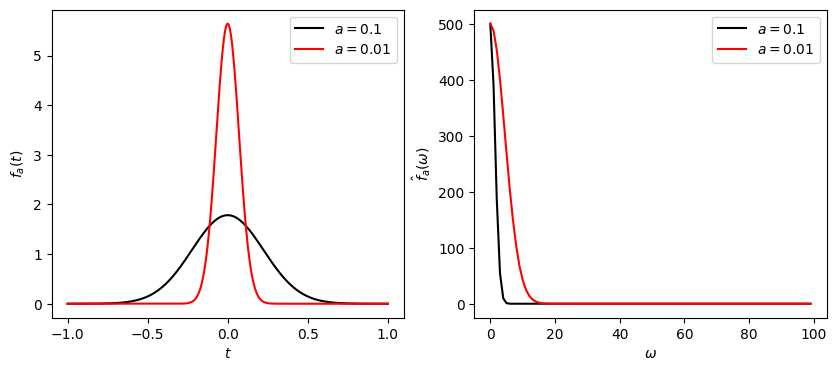

In [111]:
Npts = int(1e3)
tw = 1.
tvals = np.linspace(-tw, tw, Npts + 1)
gauss = lambda t, a: np.exp(-t**2/a)/np.sqrt(np.pi * a)
aval1 = .1
aval2 = .01
gaussvals1 = gauss(tvals, aval1)
gaussvals2 = gauss(tvals, aval2)
fft1 = np.abs(fft(gaussvals1))
fft2 = np.abs(fft(gaussvals2))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(tvals, gaussvals1, label=f"$a={aval1}$", color='k')
ax[0].plot(tvals, gaussvals2, label=f"$a={aval2}$", color='r')
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$f_{a}(t)$")
ax[0].legend()

ax[1].plot(fft1[:int(Npts/10)], label=f"$a={aval1}$", color='k')
ax[1].plot(fft2[:int(Npts/10)], label=f"$a={aval2}$", color='r')
ax[1].set_xlabel(r"$\omega$")
ax[1].set_ylabel(r"$\hat{f}_{a}(\omega)$")
ax[1].legend()

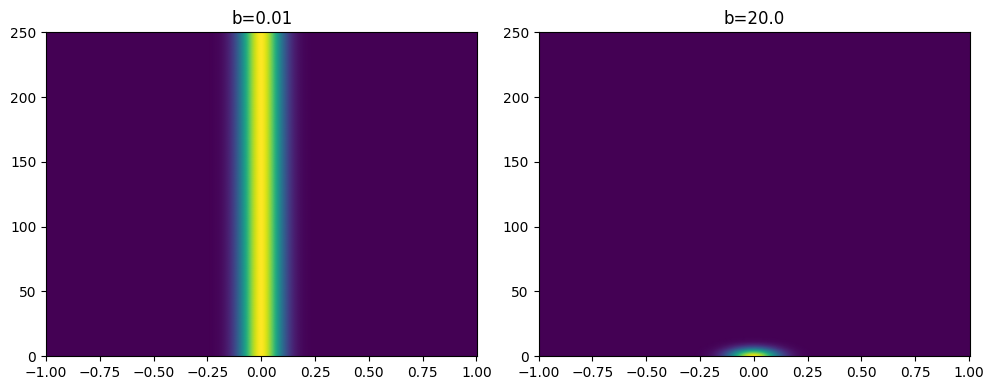

In [115]:
# Okay, this while we can deal with this analytically, dealing with it numerically is a little bit of a nightmare
# given how narrow our profiles are.  That said, if you choose seglength and noverlap to be very large, you can 
# make this do what you think it should.  

bval1 = .01
bval2 = 20.
fs = Npts/(2.*tw)
seglength = Npts - 2
f1, t1, Zxx1 = stft(gaussvals2, fs=fs, window = ('gaussian', bval1), nperseg=seglength, noverlap=seglength-2)
f2, t2, Zxx2 = stft(gaussvals2, fs=fs, window = ('gaussian', bval2), nperseg=seglength, noverlap=seglength-2)

scfac1 = np.max(np.abs(Zxx1))
scfac2 = np.max(np.abs(Zxx2))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].pcolormesh(t1-tw, f1, np.abs(Zxx1)/scfac1, shading='gouraud')
ax[0].set_title(f"b={bval1}")
ax[1].pcolormesh(t2-tw, f2, np.abs(Zxx2)/scfac2, shading='gouraud')
ax[1].set_title(f"b={bval2}")
plt.tight_layout()

So okay, cool, for a sharp feature, we now have a transform method which lets us track its behavior in both time and frequency.  This comes at a cost of losing some time resolution if we don't want to have an even more slowly decaying profile in frequency space.  

What else might we do with our short-time Fourier transform?  A really classic example is studying frequency-modulated signals.  For example, what can we say about the signal

$$
f(t) = \cos\left(2\pi f(t) t\right),  ~\omega(t) = \left(f_{0}  + (f_{1}-f_{0})\frac{t^{2}}{3t_{w}^{2}}\right)
$$

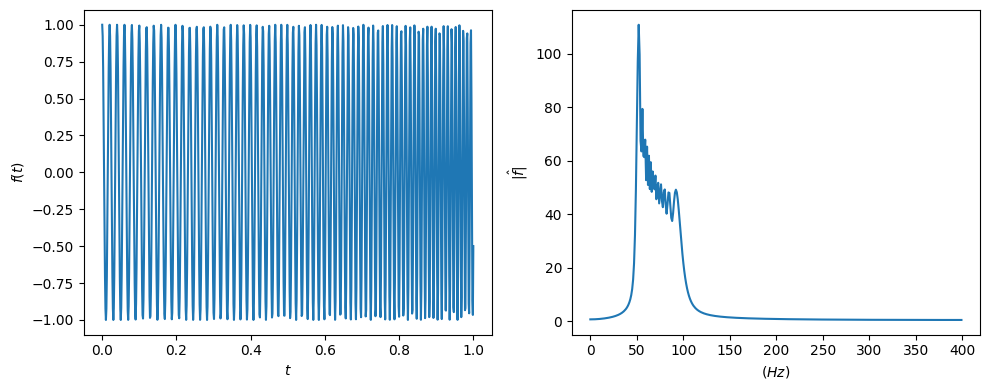

In [97]:
tpi = 2.*np.pi
chirp = lambda t, om0, om1: np.cos(tpi*t*(om0 + (om1-om0)*t**2./(3.*tw**2.)))
f0 = 50 # 50 Hz, 
f1 = 2.*f0 # 100 Hz
Npts = int(8*f1) # sample at twice the highest frequency 
tw = 1. # this is understood to be 1 second of time
tvals = np.linspace(0., tw, Npts + 1)
chirpvals = chirp(tvals, f0, f1)
fftchirp = np.abs(fft(chirpvals))

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(tvals, chirpvals)
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$f(t)$")
ax[1].plot(fftchirp[:int(fftchirp.size/2)])
ax[1].set_xlabel(r"$(Hz)$")
ax[1].set_ylabel(r"$|\hat{f}|$")
plt.tight_layout()


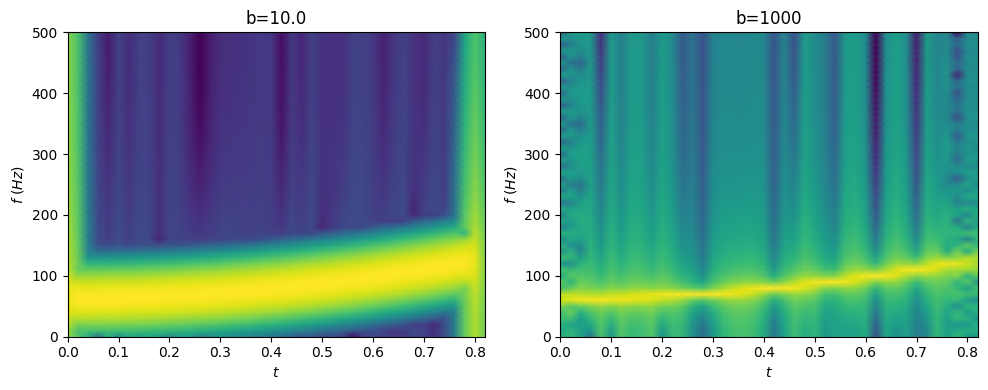

In [116]:
 # again, we have to be very thoughtful about how we choose seglength and noverlap

bval1 = 10.
bval2 = 1000
fs = Npts
seglength = int(Npts/10)
f1, t1, Zxx1 = stft(chirpvals, fs=fs, window = ('gaussian', bval1), nperseg=seglength, noverlap=seglength-20)
f2, t2, Zxx2 = stft(chirpvals, fs=fs, window = ('gaussian', bval2), nperseg=seglength, noverlap=seglength-20)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].pcolormesh(t1, f1, np.ma.log10(np.abs(Zxx1)), shading='gouraud')
ax[0].set_title(f"b={bval1}")
ax[0].set_xlabel(r"$t$")
ax[0].set_ylabel(r"$f ~(Hz)$")
ax[1].pcolormesh(t2, f2, np.ma.log10(np.abs(Zxx2)), shading='gouraud')
ax[1].set_title(f"b={bval2}")
ax[1].set_xlabel(r"$t$")
ax[1].set_ylabel(r"$f ~(Hz)$")
plt.tight_layout()

### STFS on a Wav File

In [15]:
rate, star_wars_data = wave_read('StarWars60.wav') # This is the first minute of the 
print(type(star_wars_data))

<class 'numpy.ndarray'>


In [16]:
nsamp = star_wars_data.size
star_wars_fs = nsamp/60. # number of samples taken over 60s is sampling frequency
tvals = np.linspace(0., 60., nsamp)
freqvals = np.arange(int(nsamp/2))/60.
print(f"File is sampled at {star_wars_fs} cycles/second")
freq_star = np.abs(fft(star_wars_data))

File is sampled at 22050.0 cycles/second


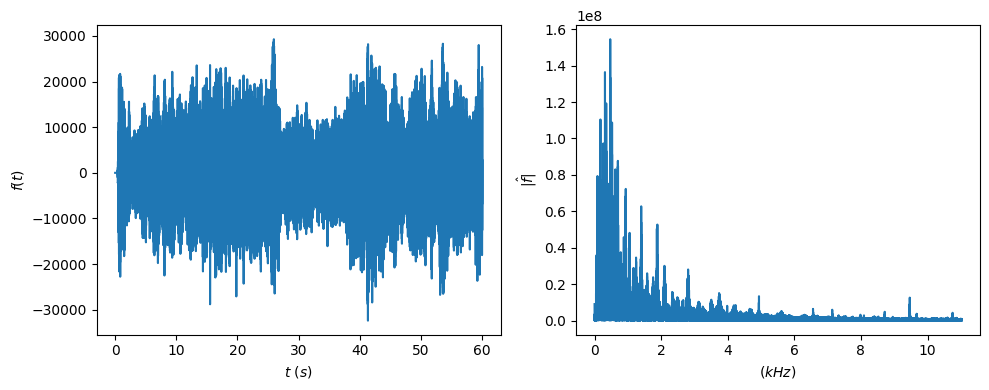

In [212]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].plot(tvals, star_wars_data)
ax[0].set_xlabel(r"$t ~(s)$")
ax[0].set_ylabel(r"$f(t)$")
ax[1].plot(freqvals/1000, freq_star[:int(nsamp/2)])
ax[1].set_xlabel(r"$(kHz)$")
ax[1].set_ylabel(r"$|\hat{f}|$")
plt.tight_layout()

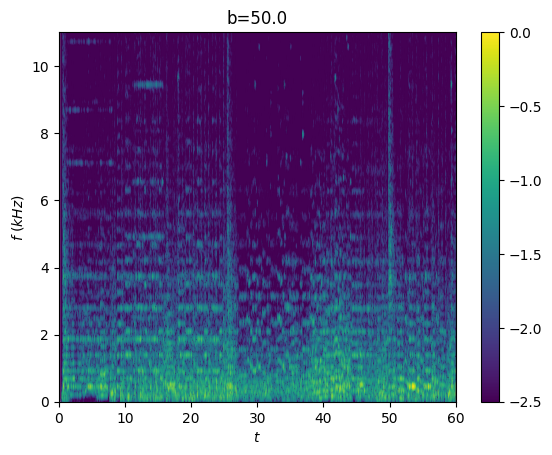

In [19]:
bval2 = 50.
seglength = int(nsamp/1000)
f2, t2, Zxx2 = stft(star_wars_data, fs=star_wars_fs, window = ('gaussian', bval2), noverlap=int(seglength/10), nperseg=seglength)
scalefac = np.max(np.abs(Zxx2))
plt.pcolormesh(t2, f2/1000, np.ma.log10(np.abs(Zxx2)/scalefac), vmin=-2.5, vmax = 0, shading='gouraud')
plt.colorbar()
plt.title(f"b={bval2}")
plt.xlabel(r"$t$")
plt.ylabel(r"$f ~(kHz)$");

## Wavelets

In [152]:
levels = 4
print(beans.shape)
coeffs = pywt.wavedec2(beans, 'db1', level=levels) # coeffs = (cA, (cH1, cV1, cD1), (cH2, cV2, cD2), etc...)

(1600, 1200)


In [153]:
nrows, ncols = coeffs[0].shape
print(coeffs[0].shape)

trows = nrows*int(2**levels)
tcols = ncols*int(2**levels)

coeffmat = np.zeros((trows, tcols))

for jj in range(levels+1):
    if jj == 0:
        coeffmat[:nrows , :ncols] = gray_scale_convert(coeffs[jj])
    else:
        sclfac = int(2**(jj-1))
        for ll in range(3):
            coeffmat[:sclfac*nrows, sclfac*ncols:2*sclfac*ncols] = gray_scale_convert(coeffs[jj][ll][:, :])
            coeffmat[sclfac*nrows:2*sclfac*nrows, :sclfac*ncols] = gray_scale_convert(coeffs[jj][ll][:, :])
            coeffmat[sclfac*nrows:2*sclfac*nrows, sclfac*ncols:2*sclfac*ncols] = gray_scale_convert(coeffs[jj][ll][:, :])

(100, 75)


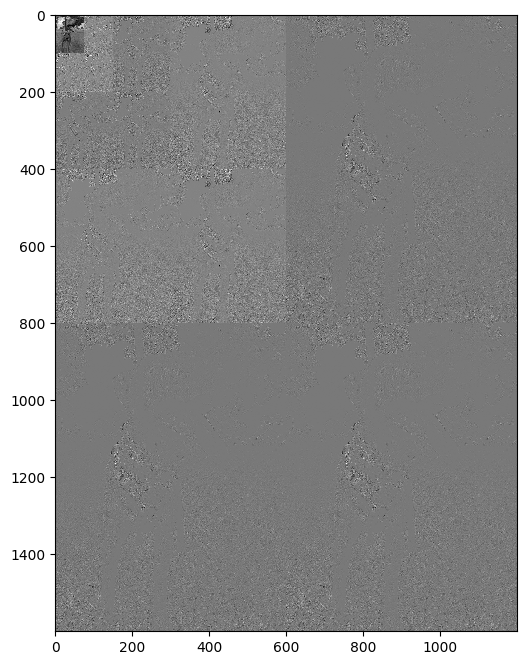

In [154]:
fig, axes = plt.subplots(1, 1, figsize=(10, 8))
axes.imshow(coeffmat, interpolation='nearest', cmap=plt.cm.grey)

In [155]:
recon = [None]*(levels+1)
recon[0] = coeffs[0]
for ll in range(levels):
    recon[ll+1] = tuple([np.zeros_like(v) for v in coeffs[ll+1]]) # zero out everything but the approximation coefficients.  
beans_approx = pywt.waverec2(tuple(recon), 'db1')

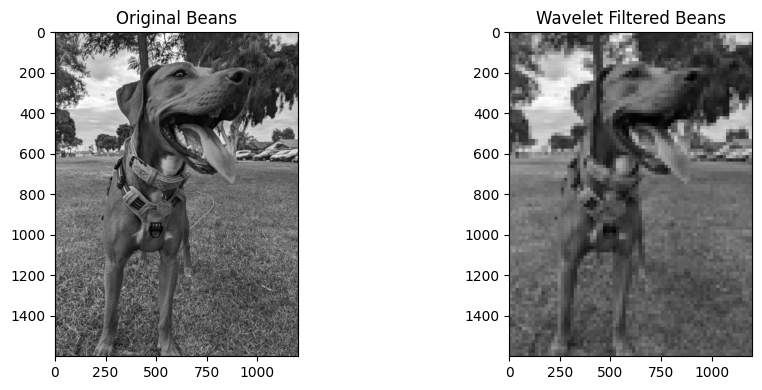

In [156]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes.ravel()
ax[0].imshow(beans, cmap=plt.cm.grey)
ax[0].set_title("Original Beans")
ax[1].imshow(gray_scale_convert(beans_approx), cmap=plt.cm.grey)
ax[1].set_title("Wavelet Filtered Beans")
plt.tight_layout()